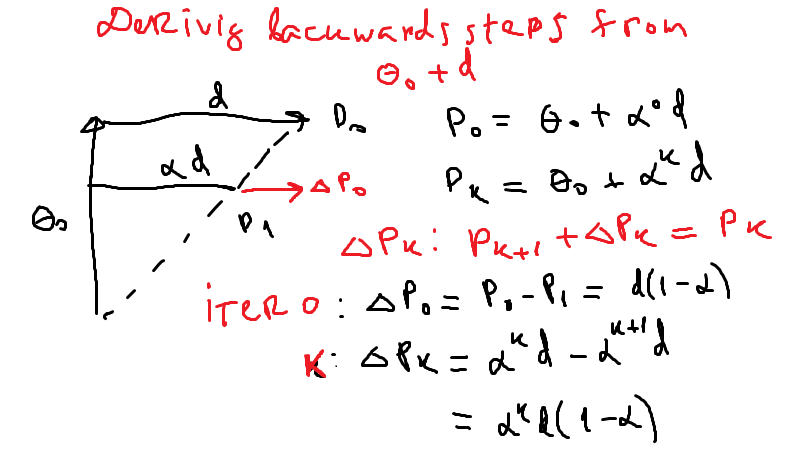

In [1]:
# had to install pip install ufal.pybox2d for environments!!!
EPS     = 1e-8
import matplotlib.pyplot as plt
import torch, gym
from tqdm import tqdm
from typing import List
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#from gym.spaces import Box, Discrete
import torch.nn as nn
from torch.distributions.categorical import Categorical # https://pytorch.org/docs/stable/distributions.html#categorical
from torch.distributions.normal import Normal           # https://pytorch.org/docs/stable/distributions.html#normal
from torch.nn.utils import parameters_to_vector         # https://pytorch.org/docs/stable/generated/torch.nn.utils.parameters_to_vector.html
from torch.optim import Adam
from IPython.display import clear_output
clear_output()

def update_model_params(model, flat_params):
    offset = 0
    for p in model.parameters():
        numel = p.numel()
        #p.data.copy_(flat_params[offset:offset+numel].view_as(p))
        p.data += flat_params[offset:offset+numel].view_as(p)
        offset += numel

In [184]:
class TRPO_env():
    """this 'wrapper' modifies env control
        automatically adds non terminal states, actions and reward into a buffer
        tracks episode rewards and calculates cumulative future rewards
        """
    def __init__(self, id, device = 'cpu', **kwargs) -> None:
        self.env = gym.make(id, **kwargs)
        self.batch_states   , self.batch_actions,       = [], []
        self.batch_rewards  , self.episode_rewards      = [], []
        self.batch_rewards_true = []
        self.env_iters          = 0
        self.device             = device
        
    def clear_batches(self):
        self.batch_states, self.batch_actions, self.batch_rewards  = [],[],[]
        
    def reset(self, **kwargs):
        """ Resets env and remembers new state"""
        state = self.env.reset()[0]
        state = torch.as_tensor(state, **kwargs)
        self.batch_states.append(state)
        self.episode_rewards    = []
        return state
    
    def step(self, action, **kwargs):
        """ On step remember action taken and reward received.
            State is not remembered because it can be terminal"""
        self.batch_actions.append(torch.as_tensor(action, **kwargs)) # tensor in case its int or array. so i can torch.stack
        state, reward, done, truncated = self.env.step(action)[:4]
        state = torch.as_tensor(state, **kwargs)
        self.episode_rewards.append(reward)
        return state, done, truncated
    
    def add_ep_rewards_2_go(self,**kwargs):
        #self.batch_rewards      += list(np.flip(np.cumsum(np.flip(self.episode_rewards))))
        ER = torch.tensor(self.episode_rewards, **kwargs)
        self.batch_rewards      += list(torch.flip(torch.cumsum(torch.flip(ER,dims=(0,)),dim=0),dims=(0,)))
        self.batch_rewards_true.append(self.episode_rewards)

    @torch.no_grad()
    def play_batch(self, policy, max_batch_size, max_ep_len = None, tqdm_iter_params = None):
        # reporting via tqdm
        if tqdm_iter_params is not None:
            tqdm_iter, tqdm_params = tqdm_iter_params
        # init
        self.clear_batches()
        policy.clear_batches()
        obs         = self.reset(**policy.tensor_params)
        t           = 0
        batch_times = []
        batch_L             = 0
        while True:
            if tqdm_iter_params is not None:
                tqdm_iter.set_postfix(**tqdm_params, batch_size = batch_L)

            action = policy.get_action(obs) 
            obs, episode_finished, episode_truncated = self.step(action, **policy.tensor_params)
            t      += 1
            do_custom_stop = False if max_ep_len is None else t >= max_ep_len
            if episode_finished or episode_truncated or do_custom_stop:
                self.env_iters += 1
                batch_times.append(t)

                self.add_ep_rewards_2_go(**policy.tensor_params)
                t = 0
                batch_L = len(self.batch_states)
                if batch_L >= max_batch_size: 
                    policy.finalize_batch() # transform policy storage lists into tensors.
                    break               # end of batch. dont add terminal obs to batch_state
                obs = self.reset(**policy.tensor_params)    # start new episode. adds obs to batch_state
            else:
                self.batch_states.append(obs)

        self.batch_states     = torch.stack(self.batch_states ).to(**policy.tensor_params)
        self.batch_actions    = torch.stack(self.batch_actions).to(**policy.tensor_params)
        self.batch_rewards    = torch.tensor(self.batch_rewards, **policy.tensor_params)
        return_rewards = self.batch_rewards_true.copy()
        self.batch_rewards_true = []
        return return_rewards
    
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class MLP(nn.Module):
    def __init__(self, inp_size, out_size, hidden_sizes, activation = nn.Tanh,activation_out = nn.Identity, lr = 1e-2) -> None:
        super().__init__()
        self.dtype          = torch.float32
        self.act            = activation
        self.act_out        = activation_out
        self.layer_sizes    = [inp_size] + hidden_sizes + [out_size]
        self.mlp            = self.seq()
        self.optimizer      = Adam(self.mlp.parameters(), lr=lr)
        self.tensor_params  = {'dtype': self.dtype, 'device': device}

    def seq(self):
        layers      = []
        for i,j in zip(self.layer_sizes[:-1],self.layer_sizes[1:]):
            layers  += [nn.Linear(i,j, dtype=self.dtype), self.act()]
        layers[-1]  = self.act_out()
        return nn.Sequential(*layers)
    
    def to(self, device):
        self.mlp.to(device)
        self.device = device  
        self.tensor_params     = {'dtype':self.dtype, 'device':self.device}
    

class torch_MLP(nn.Module):
    def __init__(self, inp_size: int, out_size: int, hidden_sizes:List[int],
                 activation = nn.Tanh, activation_out = nn.Identity, 
                 optimizer = None, lr: float = 1e-2) -> None:
        super().__init__()
        self.dtype          = torch.float32
        self.tensor_params  = {'dtype': self.dtype, 'device': device}
        self.act            = activation
        self.act_out        = activation_out
        self.dense          = self.seq([inp_size] + hidden_sizes + [out_size]).to(device)
        self.optimizer = None if optimizer is None else optimizer(self.parameters(), lr=lr)

    def seq(self, layers_size):
        layers      = []
        for i,j in zip(layers_size[:-1],layers_size[1:]):
            layers  += [nn.Linear(i,j, **self.tensor_params), self.act()]
        layers[-1]  = self.act_out()
        return nn.Sequential(*layers)
    
    def forward(self, obs):
        return self.dense(obs)

class torch_MLP_Normal(torch_MLP):
    """ inherits dense layer block, adds extra parameters"""
    def __init__(self, inp_size: int, out_size: int, hidden_sizes:List[int],
                 activation = nn.Tanh, activation_out = nn.Identity, optimizer = None, lr: float = 1e-2) -> None:
        super().__init__(inp_size, out_size, hidden_sizes, activation, activation_out, optimizer, lr)

        self.log_std = torch.nn.Parameter(0.5*torch.ones(size=(out_size,),**self.tensor_params))


class Proto_Policy():
    1

class Policy_Discrete():
    def __init__(self, obs_dim: int, num_actions:int, hidden_sizes:List[int], model = torch_MLP, activation=nn.Tanh, activation_out=nn.Identity, optimizer = None, lr: float=0.01) -> None:
        self.mlp = model(obs_dim, num_actions, hidden_sizes, activation, activation_out, optimizer, lr)
        self.tensor_params = self.mlp.tensor_params
        # for importance sampling
        self.logP_policy    = []  #batch length x 1
        self.logP_policy_old= []  #batch length x 1
        # for KL divergence
        self.logP_all       = []  #batch length x num actions
        self.logP_all_old   = []  #batch length x num actions
        # other
        self.D_KL           = torch.tensor(0.0, **self.tensor_params)
        self.U_rew          = torch.tensor(0.0, **self.tensor_params)
        self.U_rew_old      = torch.tensor(0.0, **self.tensor_params)
        self.MLP_num_prms   = sum(p.numel() for p in self.mlp.parameters())
        self.grad           = torch.zeros(size = (self.MLP_num_prms ,), **self.tensor_params)
        self.logP_grads     = None
        self.FIM            = None

    def get_policy(self, observation): # probs over actions for an obs
        return Categorical(logits=self.mlp(observation))
    
    def get_action(self, observation):
        """ Policy class: During experiment remember distribution log(P(.,s)) and log(P(a,s))
            Env class   : remember stats and actions, rewards."""
        distribution    = self.get_policy(observation)
        action          = distribution.sample()              # action taken
        self.logP_policy_old.append(distribution.log_prob(action))  # log(P(a,s))
        self.logP_all_old   .append(torch.log(distribution.probs))  # log(P(.,s))
        return action.item()
   
    def finalize_batch(self):
        self.logP_policy_old    = torch.tensor(self.logP_policy_old, **self.tensor_params)
        self.logP_all_old       = torch.stack(self.logP_all_old).to(**self.tensor_params)

    def clear_batches(self):
        self.logP_policy    = []  
        self.logP_policy_old= []  
        self.logP_all       = []  
        self.logP_all_old   = []  

    def batch_calc_logPs(self, observations, actions):
        """ Generate new log probs using current version of policy
            (on first iteration it will be the same policy = NPG)"""
        cat_dist        = self.get_policy(observations) 
        self.logP_all   = torch.log(cat_dist.probs)#.to(**self.tensor_params)     
        self.logP_policy= cat_dist.log_prob(actions)    
        
    def calc_KL_div(self):
        # logP_all uses grad, logP_all_old does not.
        temp        = torch.exp(self.logP_all_old)*(self.logP_all_old- self.logP_all)
        return temp.sum(dim=-1).mean()

    def calc_flat_grad(self, f, create_graph = False, retain_graph = True):
        # Retain by default, and by default no higher order grads.
        g = torch.autograd.grad(f, self.mlp.parameters(), create_graph = create_graph, retain_graph = retain_graph)
        return parameters_to_vector(g)
    
    def calc_logP_grads(self):
        grads = torch.zeros(size = (len(self.logP_policy),self.MLP_num_prms), **self.tensor_params)
        for i in range(len(self.logP_policy)):
            grads[i] = self.calc_flat_grad(self.logP_policy[i])
        self.logP_grads  = grads
        return self.logP_grads

    def calc_g_FIM(self, advantages):
        grad = self.logP_grads*advantages
        grad = grad.mean(dim=0)
        return grad
    
    def calc_surrogate_reward(self, advantages):
        loss = torch.exp(self.logP_policy - self.logP_policy_old)*(advantages.flatten())
        loss = loss.mean(dim = 0)
        return loss

    def calf_FIM(self, regularization = 0.001):
        FIM = self.logP_grads.unsqueeze(-1) * self.logP_grads.unsqueeze(-2) # batched outer product via broadcasting (T,N,1) * (T,1,N)
        FIM = FIM.mean(dim=0) 
        FIM += regularization * torch.eye(self.MLP_num_prms, device=device) 
        return FIM     
    
    def calc_Hessian(self, regularization = 0.001):
        """"Calculate Hessian as the Jacobian of a gradient.
            1) Create gradient of KL divergence (with graph enabled);
            2) Go through each entry and calculate gradient;
            3) drop from graph since we need to know direction once."""                     
        flat_KL_grad = self.calc_flat_grad(self.D_KL, create_graph=True)
        H = torch.zeros(size = (self.MLP_num_prms,)*2, **self.tensor_params)
        for i in range(len(flat_KL_grad)):
            H[i] = self.calc_flat_grad(flat_KL_grad[i])
        H.requires_grad_(False)
        H += regularization * torch.eye(self.MLP_num_prms, **self.tensor_params)
        return H

class value(torch_MLP):
    def __init__(self, inp_size, out_size, hidden_sizes, activation=nn.Tanh, activation_out=nn.Identity, optimizer= Adam, lr=0.01) -> None:
        super().__init__(inp_size, out_size, hidden_sizes, activation, activation_out, optimizer, lr)
        self.loss = nn.MSELoss()
    
    def train(self, observations, rewards, n_iters = 50):
        for _ in range(n_iters):
            self.optimizer.zero_grad()
            x = self(observations)
            y = rewards.reshape(x.shape)
            output = self.loss(x,y)
            output.backward()
            self.optimizer.step()


class Policy_continuous(Policy_Discrete):
    def __init__(self,  obs_dim, num_actions, hidden_sizes,
                 model = torch_MLP_Normal, activation=nn.Tanh,
                 activation_out=nn.Identity, optimizer = None, lr=0.01) -> None:
        super().__init__(obs_dim, num_actions, hidden_sizes, model, activation, activation_out, optimizer, lr)
        self.mus , self.mus_old = [], []
        self.log_std_old        = torch.zeros(size=(num_actions,), **self.tensor_params)

    def clear_batches(self):
        self.logP_policy, self.logP_policy_old  = [], [] 
        self.mus        , self.mus_old          = [], []
        
    def calc_log_prob(self, action, mu, log_std):
        """NOT USED: can be calculated using Normal(mu,std).log_prob(action)"""
        return -0.5*(torch.log(2*torch.tensor(torch.pi))+ 2*log_std + ((action - mu)/(torch.exp(log_std)+ EPS))**2)
    
    def get_policy(self, observation):
        mus  = self.mlp(observation)
        stds = self.mlp.log_std.exp()
        return Normal(mus, stds), mus, stds

    def get_action(self, observation):
        """ Data collected under old policy
            its ran within env.play_batch() with no_grad()."""
        distribution, mus, _ = self.get_policy(observation)
        action               = distribution.sample()                     # action taken
        self.logP_policy_old.append(distribution.log_prob(action))  # log(P_{old}(a,s))
        self.mus_old.append(mus.clone())
        return action.cpu().numpy()                                 # array, not int
    
    def finalize_batch(self):
        self.logP_policy_old    = torch.tensor(self.logP_policy_old, **self.tensor_params)
        self.mus_old            = torch.stack(self.mus_old)     .to(**self.tensor_params)
        self.log_std_old        = self.mlp.log_std.clone()

    def batch_calc_logPs(self, observations, actions):
        """ Analyze old data for with new policy:
            1) sample log-probs of actions observed
            2) remember mean-parameters for each observed state
            3) log-stdev will be taken straight from NN"""
        distribution, self.mus, _ = self.get_policy(observations)
        self.logP_policy= distribution.log_prob(actions).flatten()  # shape: (batch,)
        _ = 0

    def KL_div(self, mu_old, log_std_old, mu, log_std):
        var_old, var = torch.exp(2*log_std_old), torch.exp(2*log_std)
        dkl = 0.5*(((mu_old - mu)**2 + var_old)/var - 1) + log_std - log_std_old
        return dkl.sum(dim = -1).mean()
    
    def calc_KL_div(self):
        mu_old, log_std_old = self.mus_old  , self.log_std_old
        mu, log_std         = self.mus      , self.mlp.log_std
        return self.KL_div(mu_old, log_std_old, mu, log_std)

def conjugate_gradient_hess(Av, b, x0=None, max_iters = None, tol = 1e-10):
  
    x = torch.zeros_like(b) if x0 is None else x0  #init guess

    r           = b - Av(x)    # residual
    d           = r.clone()  # direction
    rr          = torch.dot(r,r)
    num_iters   = len(b) if max_iters is None else max_iters
    for _ in range(num_iters):
        Ad          = Av(d)
        step_size   = rr/ (d @ Ad)
        x           += step_size * d
        r           -= step_size * Ad
        rr_new      = torch.dot(r,r)
        if rr_new < tol: break
        d           = r + (rr_new/rr)*d
        rr          = rr_new.clone()
    return x.detach()

In [203]:
# ========= Continuous ===========
torch.cuda.empty_cache() 
env_params = {'id':'MountainCarContinuous-v0'}
env_params = {'id':'Pendulum-v1','g':9.81} #        https://www.gymlibrary.dev/environments/classic_control/pendulum/
#env_CP = TRPO_env('Pendulum-v1',  device = device, g=9.81)#
env_CP = TRPO_env(**env_params,  device = device)
num_acts = env_CP.env.action_space.shape[0]
num_obs  = env_CP.env.observation_space.shape[0]
env_CP_policy   = Policy_continuous(num_obs, num_acts   , [32])
env_CP_value    = value(    num_obs, 1          , [32], lr = 0.1)
progress     = []
progress_std = []
step_lengths = []

In [188]:
# ========= Discrete ===========
torch.cuda.empty_cache() 
# reward_cap = 300
env_params = {'id':"CartPole-v1"}
env_CP      = TRPO_env(**env_params, device=device)
num_obs     = env_CP.env.observation_space.shape[0]
num_acts    = env_CP.env.action_space.n
env_CP_policy   = Policy_Discrete( num_obs, num_acts   , [32])
env_CP_value    = value(    num_obs, 1          , [32], lr = 0.1)
progress    = []
progress_std= []
step_lengths = []

In [207]:
if 1 == 1:
    batch_size      = 3*999
    tq_iter         = tqdm(range(30))
    force_truncate  = None
    delta           = 1e-2
    backtrack_coeff = 0.8
    backtrack_iters = 10
    damping         = 0.1
    EPS             = 1e-8
    use_FIM         = False
    use_CG          = True
    CG_Iters        = 20
    inverse_regularization  = 0.001
    std_steps, avg_steps    = 0,0
    tq_prms = {'1.avg_cum_reward_mean'  :0, 
               '2.avg_cum_reward_std'   :0, 
               '3. step_len'    :0,'evals':env_CP.env_iters}
    
    step_len        = lambda k: backtrack_coeff**k*(1-backtrack_coeff) # see derivation image
    
for _ in tq_iter:
    rewards = env_CP.play_batch(env_CP_policy, batch_size, force_truncate, (tq_iter,tq_prms)) # GATHER TRAJECTORIES
    env_CP_value.train(env_CP.batch_states, env_CP.batch_rewards, n_iters=10) # fit state value function
    with torch.no_grad(): b_s = env_CP_value(env_CP.batch_states)
    advantages  = env_CP.batch_rewards.reshape(-1,1) - b_s
    advantages = (advantages - advantages.mean())/advantages.std()
    env_CP_policy.batch_calc_logPs(env_CP.batch_states, env_CP.batch_actions) # prep new log probs.
    # ====== Surrogate reward for backtracking reference ==========
    env_CP_policy.U_rew     = env_CP_policy.calc_surrogate_reward(advantages)
    env_CP_policy.U_rew_old = env_CP_policy.U_rew.clone().detach()
    # ========== Fisher Information Matrix approach ===============
    if use_FIM:
        env_CP_policy.calc_logP_grads()
        env_CP_policy.grad = env_CP_policy.calc_g_FIM(advantages)
        env_CP_policy.FIM  = env_CP_policy.calf_FIM(inverse_regularization)
        if use_CG: # only approximate inversion
            Hv = lambda v: env_CP_policy.FIM @ v
            x = conjugate_gradient_hess(Hv, env_CP_policy.grad, max_iters=CG_Iters)
        else:
            FIM_inv = torch.linalg.inv(env_CP_policy.FIM)
            x = FIM_inv @ env_CP_policy.grad
    # ================= Hessian Matrix approach ==================
    else:
        env_CP_policy.grad = env_CP_policy.calc_flat_grad(env_CP_policy.U_rew)
        # env_CP_policy.calc_logP_grads()
        # env_CP_policy.grad = env_CP_policy.calc_g_FIM(advantages)
        env_CP_policy.D_KL = env_CP_policy.calc_KL_div()
        if use_CG:  # Dont calculate H inverse, only final direction
             
            def Fvp(v):
                flat_grad_kl        = env_CP_policy.calc_flat_grad(env_CP_policy.D_KL, create_graph=True)
                flat_grad_grad_kl   = env_CP_policy.calc_flat_grad(flat_grad_kl @ v)
                return flat_grad_grad_kl + v * damping
            
            x = conjugate_gradient_hess(Fvp, env_CP_policy.grad, max_iters=CG_Iters)
        else:       # Calculate full Hessian and invert it.
            H = env_CP_policy.calc_Hessian(inverse_regularization)
            H_inv = torch.linalg.inv(H)
            x = H_inv @ env_CP_policy.grad 

    alpha = torch.sqrt(2*delta/(torch.dot(env_CP_policy.grad,x)+EPS))   # NPG step length
    update_model_params(env_CP_policy.mlp, alpha * x)                   # set NN params using NPG step

    # ======================= Backtracking Line Search ====================
    # WHAT: Eval. surrogate reward and KL divergence at NPG step params. Backtrack to old params.
    with torch.no_grad():
        backwards_fraction_traveled = 0
        for j in range(backtrack_iters):
            # update log_probs and NN parameters (mean, log_std)
            env_CP_policy.batch_calc_logPs(env_CP.batch_states, env_CP.batch_actions)
            # update Surrogate reward and KL divergence for new policy
            env_CP_policy.U_rew = env_CP_policy.calc_surrogate_reward(advantages)
            d_reward            = env_CP_policy.U_rew - env_CP_policy.U_rew_old  
            dkl                 = env_CP_policy.calc_KL_div()

            if dkl <= delta and d_reward >= 0: 
                step_lengths.append(1 - backwards_fraction_traveled)
                break # accept update
            elif    j==backtrack_iters-1:   # max iters reached. reroll weights back.
                    print(f'Could not converge in {backtrack_iters} iterations! Restarting experiment.', end= '\r')
                    update_model_params(env_CP_policy.mlp, -(1-backwards_fraction_traveled)*alpha * x ) # finish path to \theta_0
                    step_lengths.append(1 - backwards_fraction_traveled)
                    break
            else:
                step_size = step_len(j)
                update_model_params(env_CP_policy.mlp, -step_size *alpha * x )
                backwards_fraction_traveled += step_size
            
    ep_rew_sum = torch.tensor([torch.tensor(rew_ep).sum() for rew_ep in rewards])
    avg_cum_reward_std, avg_cum_reward_mean = torch.std_mean(ep_rew_sum)
    avg_cum_reward_std, avg_cum_reward_mean = avg_cum_reward_std.item(), avg_cum_reward_mean.item()
    step = (1-backwards_fraction_traveled)
    tq_prms = {'1.avg_cum_reward_mean'  :avg_cum_reward_mean, 
               '2.avg_cum_reward_std'   :avg_cum_reward_std, 
               '3. step_len'            :step, 'evals':env_CP.env_iters}
    tq_iter.set_postfix(**tq_prms)
    progress.append(avg_cum_reward_mean)
    progress_std.append(avg_cum_reward_std)
    env_CP_policy.FIM = None
    env_CP_policy.grad = None
    FIM_inv = None

 93%|█████████▎| 28/30 [06:05<00:26, 13.05s/it, 1.avg_cum_reward_mean=-1.02e+3, 2.avg_cum_reward_std=108, 3. step_len=1, batch_size=1000, evals=870] 


KeyboardInterrupt: 

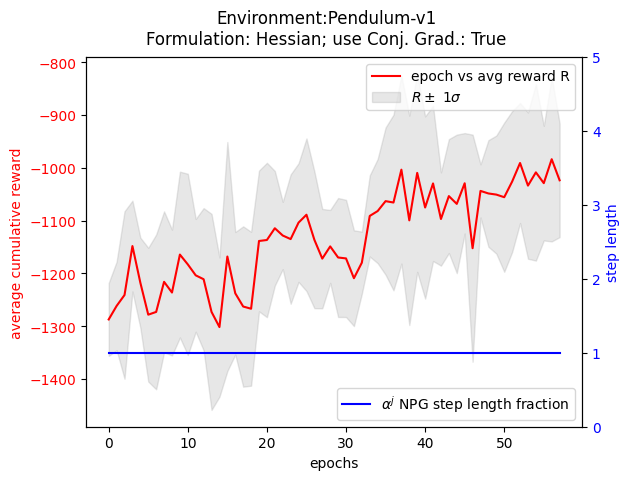

In [208]:
fig, ax1 = plt.subplots()
x = torch.arange(len(progress))
y1 = torch.tensor(progress)
y2 = torch.tensor(progress_std)
ax1.plot(x,y1, label='epoch vs avg reward R', c = 'r')    ;
ax1.fill_between(x, y1 - y2, y1 + y2, color='#888888', alpha=0.2, label='$R\pm$ 1$\sigma$')
ax1.set_xlabel('epochs')
ax1.set_ylabel('average cumulative reward', color='r')
ax1.tick_params(axis='y', labelcolor='r')
ax2 = ax1.twinx()  # instantiate a second Axes that shares the same x-axis
ax2.plot(x,step_lengths, c = 'b', label=r'$\alpha^j$ NPG step length fraction')
ax2.set_ylim(0,5)

ax2.set_ylabel('step length', color='b') 
ax2.tick_params(axis='y', labelcolor='b')
ax1.legend()
ax2.legend(loc='lower right')
plt.suptitle(f"Environment:{env_params['id']}\nFormulation: {'Hessian' if not use_FIM else 'FIM'}; use Conj. Grad.: {use_CG }");

In [209]:
n= 999
env_CP_policy.clear_batches()


env = gym.make(**env_params, render_mode="human")


try:
    observation, info = env.reset(seed=82)
    observation = torch.tensor(observation, device=device)
    for _ in tqdm(range(n)):
        action = env_CP_policy.get_action(observation)
        observation,reward, terminated, truncated, info = env.step(action)
        observation = torch.tensor(observation, device=device)
        #print("info : ",info);
        
        if terminated or truncated:
            observation, info = env.reset()
            break
    env.close()
except: 
    env.close()


  0%|          | 0/999 [00:00<?, ?it/s]c:\Users\Hot Mexican\VS_Code_Proj\.venv\lib\site-packages\gym\utils\passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):
 20%|█▉        | 199/999 [00:06<00:27, 29.57it/s]
